<a href="https://colab.research.google.com/github/pdrzxzz/satellite-image-classification/blob/main/micro_organism_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# !pip install kaggle
!pip install albumentations

In [42]:
# ============================== #
#         Import Libraries       #
# ============================== #

# Essential libraries for machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing from albumentations (Image augmentation)
import albumentations as A

# Image processing from skimage
from skimage import img_as_ubyte # Convert grayscale image to unsigned 8-bit format (required by LBP)
from skimage.io import imread  # To read image files
from skimage.transform import resize  # To resize images
from skimage.feature import local_binary_pattern  # To extract texture
from skimage import filters # sobel, prewitt... # To extract edges

# Scikit-learn Data processing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Scikit-learn modules for training and evaluation
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# Utilities
import kagglehub  # To download datasets directly from Kaggle using KaggleHub
import os  # For interacting with the operating system, such as file paths
import joblib # Save models

In [44]:
# ========================================== #
#      Constants and Configurations          #
# ========================================== #

# Features to be extracted from images
# FEATURES = ['gray', 'color', 'lbp', 'sobel']
FEATURES = ['lbp']

# Number of images to use from each class (can be limited for faster runs or place a huge value to use all the images)
NUM_IMAGES_PER_CLASS = 100000

# Size to which all images will be resized (width, height)
IMAGE_SIZE = (64, 64)

# Parameters for Local Binary Patterns (LBP)
LBP_RADIUS = 1                  # Radius of circle for LBP
LBP_N_POINTS = 8 * LBP_RADIUS  # Number of points to consider in LBP

# Random state for reproducibility in splitting and models
RANDOM_STATE = 0

# Define default augmentation pipeline
AUGMENTATION_PIPELINE = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2),
    A.Rotate(limit=15, p=0.3),
])

In [14]:
# ============================== #
#        Download Dataset        #
# ============================== #

# Download dataset from Kaggle using KaggleHub
path = kagglehub.dataset_download("mdwaquarazam/microorganism-image-classification")

# Path to the folder containing the image dataset
data_path = os.path.join(path, os.listdir(path)[0])

# List all image classes (subdirectories) in the dataset folder, sorted for consistency
image_classes = sorted(os.listdir(data_path))

# Print dataset location and classes found for confirmation
print("Dataset directory:", data_path)
print("Classes found:", image_classes)

Dataset directory: /kaggle/input/microorganism-image-classification/Micro_Organism
Classes found: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


In [43]:
# ========================================== #
#      Image Processing & Feature Utils      #
# ========================================== #

def load_and_resize_image(image_path, as_gray=True, augment=True):
    """
    Load an image from disk, resize it, optionally apply augmentation, and return the result.

    Parameters:
    - image_path (str): Path to the image file.
    - as_gray (bool): Load the image as grayscale if True; otherwise, as color.
    - augment (bool): Whether to apply Albumentations image augmentation.

    Returns:
    - np.ndarray: The resized (and possibly augmented) image.
    """
    image = imread(image_path, as_gray=as_gray)
    image = resize(image, IMAGE_SIZE, anti_aliasing=True)

    if augment:
        # Convert to uint8 format required by Albumentations
        image_uint8 = img_as_ubyte(image)

        if as_gray:
            # Albumentations expects grayscale images to have shape (H, W, 1)
            image_uint8 = image_uint8[..., np.newaxis]

        # Apply augmentation pipeline
        augmented = AUGMENTATION_PIPELINE(image=image_uint8)
        image_aug = augmented["image"]

        # Convert back to float32 normalized between 0 and 1
        image_aug = image_aug.astype(np.float32) / 255.0

        if as_gray:
            image_aug = image_aug[..., 0]  # Remove channel dimension

        return image_aug

    return image

def extract_color_histograms(image):
    """
    Extract 256-bin histogram features for each RGB channel and concatenate.

    Parameters:
    - image (np.ndarray): Color image array.

    Returns:
    - np.ndarray: Concatenated histogram vector (length 256 * 3 = 768).
    """

    # If image is grayscale, convert it to 3-channel by repeating it
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)

    # For each color channel (R,G,B), compute histogram counts
    histograms = [
        np.histogram(image[:, :, channel], bins=256, range=(0, 256))[0]
        for channel in range(3)
    ]
    # Concatenate histograms of all channels into one feature vector
    concatenated_hist = np.concatenate(histograms)
    return concatenated_hist

def extract_lbp_features(gray_image):
    """
    Compute Local Binary Pattern (LBP) histogram for a grayscale image.

    Parameters:
    - gray_image (np.ndarray): Grayscale image array.

    Returns:
    - np.ndarray: Normalized histogram of LBP patterns.
    """
    # Convert grayscale image to unsigned 8-bit format (required by LBP)
    image_uint8 = img_as_ubyte(gray_image)

    # Compute LBP using 'uniform' method
    lbp = local_binary_pattern(image_uint8, LBP_N_POINTS, LBP_RADIUS, method="uniform")

    # Define number of bins for histogram
    n_bins = LBP_N_POINTS + 2  # Number of possible LBP patterns in uniform method

    # Calculate normalized histogram of LBP
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return lbp_hist

In [33]:
# ========================================== #
#          Dataset Feature Extraction        #
# ========================================== #

def process_dataset(features=["gray"]):
    """
    Load dataset images, extract selected features and encode labels.

    Parameters:
    - features (list of str): Feature types to extract.
        Options include 'gray', 'color', 'lbp', 'sobel', 'prewitt'.

    Returns:
    - X (np.ndarray): Feature matrix of shape (num_samples, num_features).
    - y (np.ndarray): Encoded integer labels for each sample.
    """
    # Dictionary to hold lists of extracted features per feature type
    feature_arrays = {f: [] for f in features}

    # List to store string labels (class names)
    labels = []

    # Iterate over each class folder
    for image_class in image_classes:
        print(f"Processing class: {image_class}")
        class_path = os.path.join(data_path, image_class)

        # List all image files in the class folder, limit by NUM_IMAGES_PER_CLASS
        image_list = os.listdir(class_path)[:NUM_IMAGES_PER_CLASS]

        # Process each image file in the current class
        for idx, image_file in enumerate(image_list):
            img_path = os.path.join(class_path, image_file)

            # Load grayscale image resized to fixed size
            gray = load_and_resize_image(img_path, as_gray=True)

            # Append class label string to labels list
            labels.append(image_class)

            # Extract and append grayscale flattened pixels if requested
            if "gray" in features:
                feature_arrays["gray"].append(gray.flatten())

            # Extract and append color histograms if requested
            if "color" in features:
                color_img = load_and_resize_image(img_path, as_gray=False)
                feature_arrays["color"].append(extract_color_histograms(color_img))

            # Extract and append LBP histogram if requested
            if "lbp" in features:
                feature_arrays["lbp"].append(extract_lbp_features(gray))

            # Extract and append Sobel edge features if requested
            if "sobel" in features:
                sobel_img = filters.sobel(gray)
                feature_arrays["sobel"].append(sobel_img.flatten())

            # Extract and append Prewitt edge features if requested
            if "prewitt" in features:
                prewitt_img = filters.prewitt(gray)
                feature_arrays["prewitt"].append(prewitt_img.flatten())

            # Progress print on the same line for convenience
            print(f"\r{idx + 1}/{len(image_list)}", end="", flush=True)
        print()  # New line after finishing a class

    # Encode string labels to integers (e.g., "forest"->0, "urban"->1, etc.)
    labels_encoded = LabelEncoder().fit_transform(labels)

    # List to hold scaled feature arrays for each requested feature type
    scaled_features = []

    # Normalize each feature array independently using StandardScaler (mean=0, std=1)
    for f in features:
        array = np.array(feature_arrays[f])
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(array)
        scaled_features.append(scaled_array)

    # Concatenate features horizontally if multiple feature types requested
    if len(scaled_features) > 1:
        X = np.concatenate(scaled_features, axis=1)
    else:
        X = scaled_features[0]

    # Return final feature matrix and encoded labels as numpy arrays
    return X, labels_encoded

In [17]:
# ========================================== #
#      Model Evaluation and Visualization    #
# ========================================== #

def plot_learning_curve(model, X, y, title="Learning Curve", scoring="accuracy", cv_splits=5):
    """
    Plot the learning curve for a given model and dataset.

    Parameters:
    - model (estimator): A scikit-learn estimator (e.g., RandomForestClassifier).
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Target labels.
    - title (str): Title for the plot.
    - scoring (str): Metric to evaluate model performance (default = 'accuracy').
    - cv_splits (int): Number of cross-validation folds.
    """
    # Create a stratified K-fold split strategy
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)

    # Define relative sizes of training data to evaluate
    train_sizes = np.linspace(0.05, 0.95, 19)

    # Compute training and validation scores for different training sizes
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    # Compute mean and standard deviation for error bands
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes_abs, train_mean, 'o-', label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    plt.plot(train_sizes_abs, val_mean, 'o-', label='Validation Accuracy', color='green')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

    # X-axis in percentage form for clarity
    percent_labels = [f"{int(p * 100)}%" for p in train_sizes]
    plt.xticks(train_sizes_abs, percent_labels, rotation=45)

    # Set plot titles and labels
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Training Set Size (%)")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [18]:
# ========================================== #
#                  Training                  #
# ========================================== #

def train_grid_search(classifier, param_grid, X_train, X_test, y_train, y_test):
    """
    Perform hyperparameter tuning with GridSearchCV on Classifier.

    Parameters:
    - classifier: estimator object (e.g. RandomForestClassifier)
    - param_grid: dict, hyperparameters grid for GridSearchCV
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Labels.

    Returns:
    - best_model (estimator): Best estimator after grid search.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=3
    )
    grid_search.fit(X_train, y_train)
    print("Best hyperparameters found:", grid_search.best_params_)
    test_accuracy = accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))
    print(f"Test accuracy with best model: {test_accuracy:.4f}")
    return grid_search.best_estimator_


In [32]:
# ========================================== #
#                Run Pipeline                #
# ========================================== #

X, y = process_dataset(FEATURES)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.1, random_state=RANDOM_STATE)

Processing class: Amoeba
72/72
Processing class: Euglena
168/168
Processing class: Hydra
76/76
Processing class: Paramecium
152/152
Processing class: Rod_bacteria
85/85
Processing class: Spherical_bacteria
86/86
Processing class: Spiral_bacteria
75/75
Processing class: Yeast
75/75


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................n_estimators=10;, score=0.296 total time=   0.0s
[CV 2/5] END ...................n_estimators=10;, score=0.303 total time=   0.0s
[CV 3/5] END ...................n_estimators=10;, score=0.310 total time=   0.0s
[CV 4/5] END ...................n_estimators=10;, score=0.310 total time=   0.0s
[CV 5/5] END ...................n_estimators=10;, score=0.282 total time=   0.0s
[CV 1/5] END ...................n_estimators=50;, score=0.324 total time=   0.1s
[CV 2/5] END ...................n_estimators=50;, score=0.359 total time=   0.1s
[CV 3/5] END ...................n_estimators=50;, score=0.373 total time=   0.1s
[CV 4/5] END ...................n_estimators=50;, score=0.345 total time=   0.1s
[CV 5/5] END ...................n_estimators=50;, score=0.366 total time=   0.1s
[CV 1/5] END ..................n_estimators=100;, score=0.268 total time=   0.2s
[CV 2/5] END ..................n_estimators=100;,

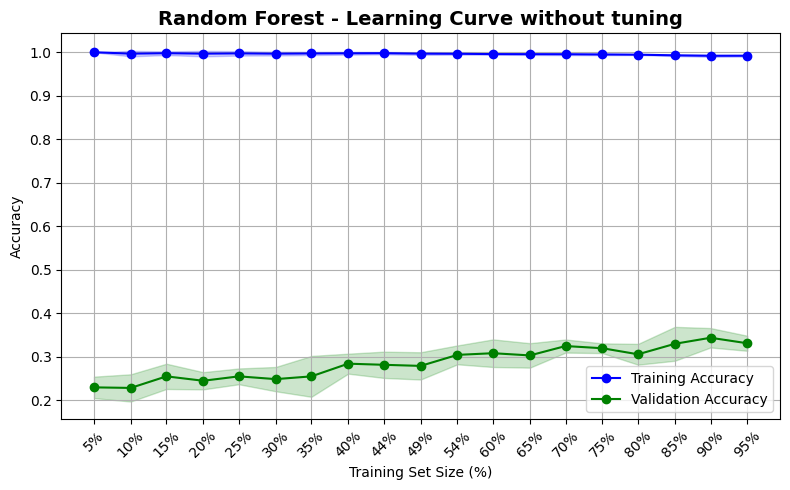

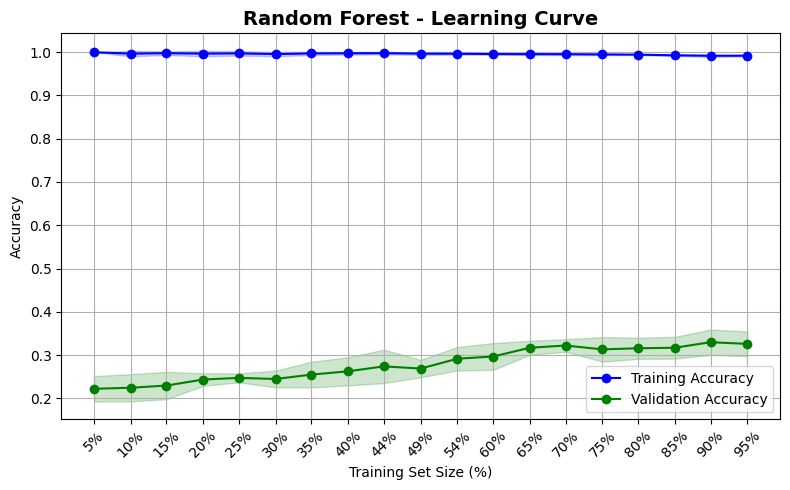

In [34]:
# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100],            # Number of trees
    # 'max_depth': [5, 10],           # Max depth of trees
    # 'min_samples_split': [6, 12, 48],           # Min samples required to split node
    # 'min_samples_leaf': [8, 16],             # Min samples required at leaf node
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

best_rf_model = train_grid_search(rf_model, param_grid_rf, X_train, X_test, y_train, y_test)

plot_learning_curve(RandomForestClassifier(), X, y, title="Random Forest - Learning Curve without tuning")
plot_learning_curve(best_rf_model, X, y, title="Random Forest - Learning Curve")

In [ ]:
# Define hyperparameter grid for SVC
param_grid_svc = {
    'C': [0.1, 1, 10, 100],          # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'degree': [2, 3, 4],             # Degree for 'poly' kernel
    'gamma': ['scale', 'auto'],      # Kernel coefficient
}

svc_model = SVC(random_state=RANDOM_STATE)

best_svc_model = train_grid_search(svc_model, param_grid_svc, X_train, X_test, y_train, y_test)

# Plot learning curves
plot_learning_curve(SVC(), X, y, title="SVC - Learning Curve without tuning")
plot_learning_curve(best_svc_model, X, y, title="SVC - Learning Curve")

In [ ]:
# Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 6, 12, 24],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2'],
}

dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
best_dt_model = train_grid_search(dt_model, param_grid_dt, X_train, X_test, y_train, y_test)

plot_learning_curve(DecisionTreeClassifier(), X, y, title="Decision Tree - Learning Curve without tuning")
plot_learning_curve(best_dt_model, X, y, title="Decision Tree - Learning Curve")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.232 total time=   0.9s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.204 total time=   1.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.289 total time=   1.1s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.183 total time=   1.9s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.239 total time=   1.5s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.303 total time=   1.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.246 total time=   0.9s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.289 total time=   1.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.254 total time=   0.7s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=

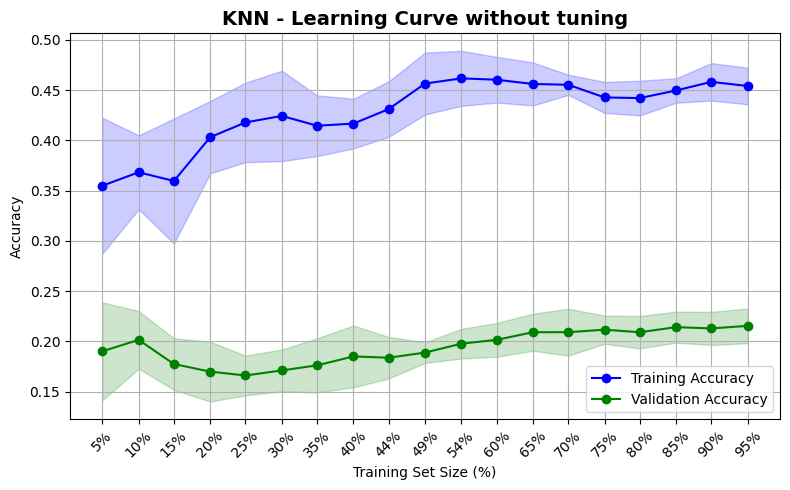

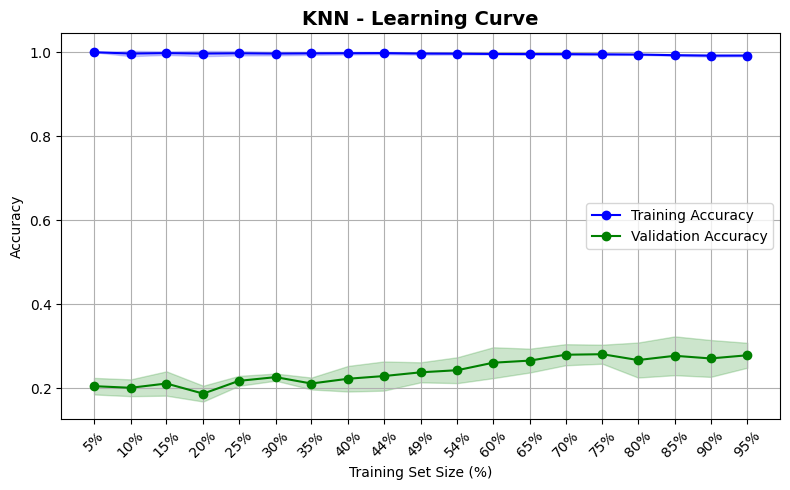

In [22]:
# KNN
param_grid_knn = {
    'n_neighbors': [15, 30, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean'],
}

knn_model = KNeighborsClassifier()
best_knn_model = train_grid_search(knn_model, param_grid_knn, X_train, X_test, y_train, y_test)

plot_learning_curve(KNeighborsClassifier().fit(X_train, y_train), X, y, title="KNN - Learning Curve without tuning")
plot_learning_curve(best_knn_model, X, y, title="KNN - Learning Curve")